In [2]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

In [4]:
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [4]:
def detect_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        return None

    x, y, w, h = faces[0]
    face = image[y:y+h, x:x+w]
    face = cv2.resize(face, (224, 224))

    return face

Using device: cuda
Epoch [1/20], Train Loss: 1.8367, Test Loss: 1.7836, Train Acc: 14.96%, Test Acc: 15.38%, F1: 0.1029
New best model saved with accuracy: 15.38%
Epoch [2/20], Train Loss: 1.6612, Test Loss: 1.7278, Train Acc: 33.72%, Test Acc: 21.68%, F1: 0.1800
New best model saved with accuracy: 21.68%
Epoch [3/20], Train Loss: 1.5146, Test Loss: 1.6674, Train Acc: 56.30%, Test Acc: 30.07%, F1: 0.3102
New best model saved with accuracy: 30.07%
Epoch [4/20], Train Loss: 1.3476, Test Loss: 1.5608, Train Acc: 67.45%, Test Acc: 44.06%, F1: 0.5015
New best model saved with accuracy: 44.06%
Epoch [5/20], Train Loss: 1.1919, Test Loss: 1.4349, Train Acc: 75.95%, Test Acc: 53.15%, F1: 0.5672
New best model saved with accuracy: 53.15%
Epoch [6/20], Train Loss: 1.0157, Test Loss: 1.3509, Train Acc: 79.47%, Test Acc: 53.85%, F1: 0.5520
New best model saved with accuracy: 53.85%
Epoch [7/20], Train Loss: 0.9077, Test Loss: 1.2962, Train Acc: 80.06%, Test Acc: 57.34%, F1: 0.5897
New best model s

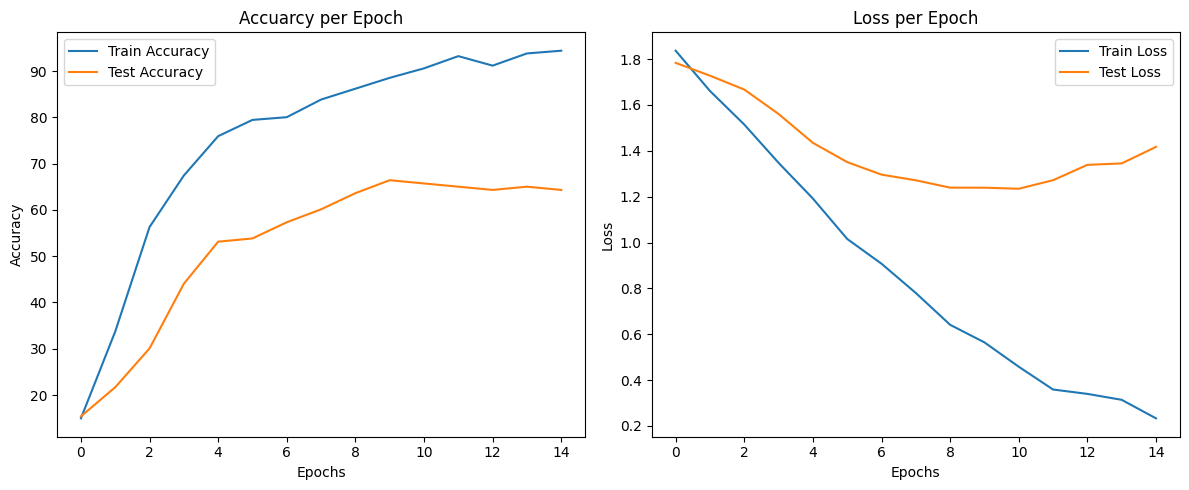

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to dataset
train_dir = "CK_dataset/train"
test_dir = "CK_dataset/test"

# Minimal transforms with light augmentation
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Mild augmentation
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
test_dataset = ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# EfficientNet-B1 with mild dropout
efficientnet_model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)
num_features = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier = nn.Sequential(
    nn.Dropout(0.3),  # Mild dropout
    nn.Linear(num_features, 6)  # 6 classes
)

# Compute class weights
labels = np.array([label for _, label in train_dataset.samples])
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

efficientnet_model.to(device)

# Loss and optimizer with light weight decay
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.0001, weight_decay=1e-4)

# Training setup
num_epochs = 20
best_acc = 0.0
patience = 5
counter = 0

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    efficientnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = efficientnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total  # Fixed typo here
    train_loss = running_loss / len(train_loader)
    train_acc_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    # Evaluation
    efficientnet_model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = efficientnet_model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * correct_test / total_test
    test_loss_avg = test_loss / len(test_loader)
    test_acc_list.append(test_accuracy)
    test_loss_list.append(test_loss_avg)

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Test Loss: {test_loss_avg:.4f}, '
          f'Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%, '
          f'F1: {f1:.4f}')

    if test_accuracy > best_acc:
        best_acc = test_accuracy
        torch.save(efficientnet_model.state_dict(), "best_efficientnet_b1_ck.pth")
        print(f"New best model saved with accuracy: {best_acc:.2f}%")
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Patience counter: {counter}/{patience}")
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Final evaluation
efficientnet_model.load_state_dict(torch.load("best_efficientnet_b1_ck.pth"))
efficientnet_model.eval()

correct_final = 0
total_final = 0
test_loss_final = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet_model(images)
        loss = criterion(outputs, labels)
        test_loss_final += loss.item()
        _, predicted = outputs.max(1)
        total_final += labels.size(0)
        correct_final += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = 100 * correct_final / total_final
final_test_loss = test_loss_final / len(test_loader)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

# Classification report
class_names = train_dataset.classes  # Get class names from dataset
print("\n" + "="*50)
print("Classification Report")
print("="*50)
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# Summary
print("\n" + "="*50)
print("Training Completed - Final Evaluation")
print("="*50)
print(f"Best Test Accuracy Achieved: {best_acc:.2f}%")
print(f"Final Model Performance (Loaded Best Model):")
print(f"  Test Accuracy: {final_accuracy:.2f}%")
print(f"  Test Loss: {final_test_loss:.4f}")
print(f"  Precision (weighted): {precision:.4f}")
print(f"  Recall (weighted): {recall:.4f}")
print(f"  F1-Score (weighted): {f1:.4f}")

print("\nTraining Statistics Summary:")
print(f"  Final Train Accuracy: {train_acc_list[-1]:.2f}%")
print(f"  Final Test Accuracy: {test_acc_list[-1]:.2f}%")
print(f"  Final Train Loss: {train_loss_list[-1]:.4f}")
print(f"  Final Test Loss: {test_loss_list[-1]:.4f}")
print(f"  Overfitting Indicator (Train - Test Acc): {(train_acc_list[-1] - test_acc_list[-1]):.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuarcy per Epoch")

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss per Epoch")

plt.tight_layout()
plt.show()

Using device: cuda
Epoch [1/20], Train Loss: 1.8092, Test Loss: 1.8022, Train Acc: 17.97%, Test Acc: 20.00%, F1: 0.1397
New best model saved with accuracy: 20.00%
Epoch [2/20], Train Loss: 1.6450, Test Loss: 1.7864, Train Acc: 37.50%, Test Acc: 21.82%, F1: 0.1801
New best model saved with accuracy: 21.82%
Epoch [3/20], Train Loss: 1.5243, Test Loss: 1.7540, Train Acc: 60.94%, Test Acc: 23.64%, F1: 0.2085
New best model saved with accuracy: 23.64%
Epoch [4/20], Train Loss: 1.4338, Test Loss: 1.7092, Train Acc: 69.53%, Test Acc: 36.36%, F1: 0.3060
New best model saved with accuracy: 36.36%
Epoch [5/20], Train Loss: 1.3151, Test Loss: 1.6679, Train Acc: 80.47%, Test Acc: 40.00%, F1: 0.3367
New best model saved with accuracy: 40.00%
Epoch [6/20], Train Loss: 1.2157, Test Loss: 1.6318, Train Acc: 79.69%, Test Acc: 45.45%, F1: 0.3797
New best model saved with accuracy: 45.45%
Epoch [7/20], Train Loss: 1.0603, Test Loss: 1.5891, Train Acc: 90.62%, Test Acc: 49.09%, F1: 0.4123
New best model s

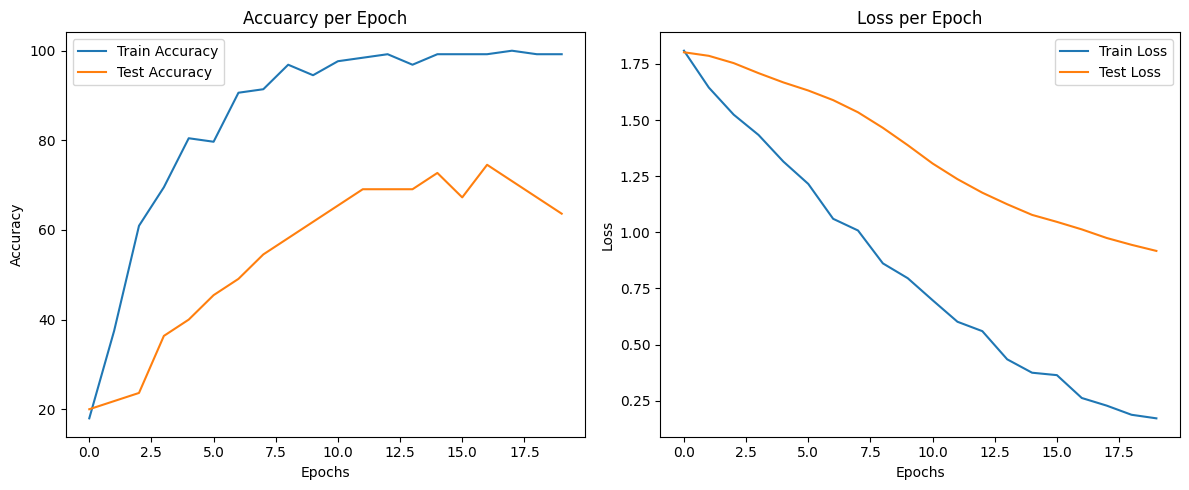

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to dataset
train_dir = "JAFFE-[70,30]/train"
test_dir = "JAFFE-[70,30]/test"

# Minimal transforms with light augmentation
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Mild augmentation
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
test_dataset = ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# EfficientNet-B1 with mild dropout
efficientnet_model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)
num_features = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier = nn.Sequential(
    nn.Dropout(0.3),  # Mild dropout
    nn.Linear(num_features, 6)  # 6 classes
)

# Compute class weights
labels = np.array([label for _, label in train_dataset.samples])
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

efficientnet_model.to(device)

# Loss and optimizer with light weight decay
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.0001, weight_decay=1e-4)

# Training setup
num_epochs = 20
best_acc = 0.0
patience = 5
counter = 0

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    efficientnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = efficientnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_acc_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    # Evaluation
    efficientnet_model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = efficientnet_model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * correct_test / total_test
    test_loss_avg = test_loss / len(test_loader)
    test_acc_list.append(test_accuracy)
    test_loss_list.append(test_loss_avg)

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Test Loss: {test_loss_avg:.4f}, '
          f'Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%, '
          f'F1: {f1:.4f}')

    if test_accuracy > best_acc:
        best_acc = test_accuracy
        torch.save(efficientnet_model.state_dict(), "best_efficientnet_b1_jaffe.pth")
        print(f"New best model saved with accuracy: {best_acc:.2f}%")
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Patience counter: {counter}/{patience}")
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Final evaluation
efficientnet_model.load_state_dict(torch.load("best_efficientnet_b1_jaffe.pth"))
efficientnet_model.eval()

correct_final = 0
total_final = 0
test_loss_final = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet_model(images)
        loss = criterion(outputs, labels)
        test_loss_final += loss.item()
        _, predicted = outputs.max(1)
        total_final += labels.size(0)
        correct_final += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = 100 * correct_final / total_final
final_test_loss = test_loss_final / len(test_loader)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

# Classification report
class_names = train_dataset.classes  # Get class names from dataset
print("\n" + "="*50)
print("Classification Report")
print("="*50)
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# Summary
print("\n" + "="*50)
print("Training Completed - Final Evaluation")
print("="*50)
print(f"Best Test Accuracy Achieved: {best_acc:.2f}%")
print(f"Final Model Performance (Loaded Best Model):")
print(f"  Test Accuracy: {final_accuracy:.2f}%")
print(f"  Test Loss: {final_test_loss:.4f}")
print(f"  Precision (weighted): {precision:.4f}")
print(f"  Recall (weighted): {recall:.4f}")
print(f"  F1-Score (weighted): {f1:.4f}")

print("\nTraining Statistics Summary:")
print(f"  Final Train Accuracy: {train_acc_list[-1]:.2f}%")
print(f"  Final Test Accuracy: {test_acc_list[-1]:.2f}%")
print(f"  Final Train Loss: {train_loss_list[-1]:.4f}")
print(f"  Final Test Loss: {test_loss_list[-1]:.4f}")
print(f"  Overfitting Indicator (Train - Test Acc): {(train_acc_list[-1] - test_acc_list[-1]):.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuarcy per Epoch")

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss per Epoch")

plt.tight_layout()
plt.show()

Final Test Accuracy: 66.43%


<Figure size 800x600 with 0 Axes>

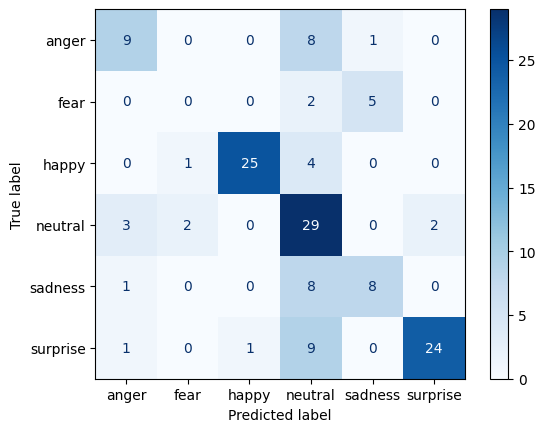

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
efficientnet_model.eval()
y_true = []
y_pred = []
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = efficientnet_model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
final_test_accuracy = 100 * correct / total
print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")

conf_matrix = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=train_dataset.classes)

plt.figure(figsize=(8, 6))
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

Angry


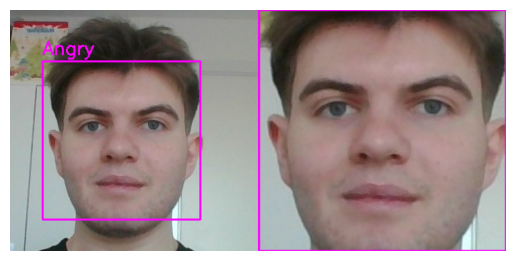

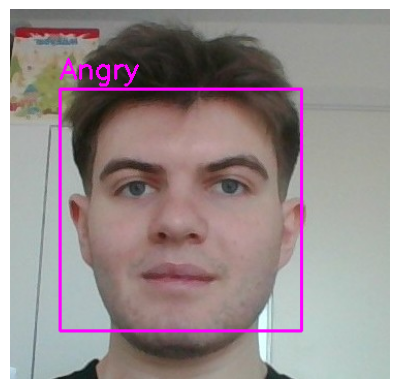

In [14]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# Function to detect face
def detect_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        return None, None

    x, y, w, h = faces[0]
    face = image[y:y+h, x:x+w]
    return face, (x, y, w, h)

# Load the image
image = cv2.imread("images/simon1.jpg")
face, bbox = detect_face(image)

# Draw a rectangle around the detected face
if bbox is not None:
    x, y, w, h = bbox
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 255), 2)

# Convert the face to a PIL image
face_pil = Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

# Convert the face to a tensor
face_tensor = transforms.ToTensor()(face_pil).unsqueeze(0).to(device)

# Get the model's prediction
outputs = efficientnet_model(face_tensor)
_, predicted = outputs.max(1)
predicted_class = train_dataset.classes[predicted.item()]
print(predicted_class)

# Show the original image with the rectangle
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Overlay the predicted class on the image
cv2.putText(image_rgb, predicted_class, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 255), 2)

# Resize the face to match the height of the original image
resized_face = cv2.resize(cv2.cvtColor(face, cv2.COLOR_BGR2RGB), (image_rgb.shape[1], image_rgb.shape[0]))

# Combine the original image and the face image
combined_image = cv2.hconcat([image_rgb, resized_face])

# Display the combined image
plt.imshow(combined_image)
plt.axis('off')  # Hide the axis
plt.show()

# Display the image with the EfficientNet prediction
plt.imshow(image_rgb)
plt.axis('off')  # Hide the axis
plt.show()

Probabilities: tensor([[0.1167, 0.1950, 0.3788, 0.1950, 0.1031, 0.0114]], device='cuda:0')
Predicted class: happy


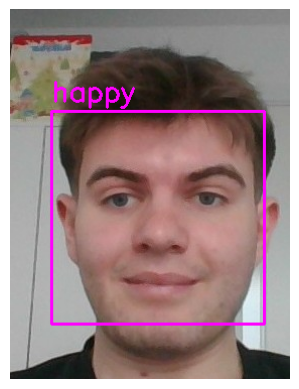

In [9]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms


# Define prediction transforms matching training
predict_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to detect face
def detect_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        return None, None
    x, y, w, h = faces[0]
    face = image[y:y+h, x:x+w]
    return face, (x, y, w, h)

# Load the image
image = cv2.imread("images/simon5.jpg")
face, bbox = detect_face(image)

if face is None:
    print("No face detected!")
else:
    # Draw rectangle around the detected face
    x, y, w, h = bbox
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 255), 2)

    # Convert and preprocess face
    face_pil = Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    face_tensor = predict_transforms(face_pil).unsqueeze(0).to(device)

    # Get prediction
    efficientnet_model.eval()
    with torch.no_grad():
        outputs = efficientnet_model(face_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        print("Probabilities:", probabilities)
        _, predicted = outputs.max(1)
        predicted_class = train_dataset.classes[predicted.item()]
        print("Predicted class:", predicted_class)

    # Overlay prediction on image
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.putText(image_rgb, predicted_class, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 255), 2)

    # Display
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()